# Static Stack Usage Survey

Here are the results of my static analysis of popular open source applications' stack memory usage. This notebook is designed to process CSV files generated by [EscapeAnalysisTool](https://github.com/bencole12345/EscapeAnalysisTool).

So far I analyse three sets of results:

- Grep, compiled to LLVM IR
- Grep, compiled to LLVM IR with a failed attempt to force it to use static linking
- `ocamlrun` compiled to LLVM IR (haven't attempted static linking on this one yet)

I performed the decompilation using [RetDec](https://retdec.com). For compiling to LLVM IR I used [GLLVM](https://github.com/SRI-CSL/gllvm) to emit LLVM bitcode followed by the command-line tool `llvm-dis` to get a `.ll` file for EscapeAnalysisTool.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Where the functions to display statistics are located
from plotting import plot_stack_allocation_histograms, plot_stack_allocation_CDFs, print_statistics

# Set up the theme when working locally
try:
    from jupyterthemes import jtplot
    # jtplot.style()
except:
    pass

data_dir = Path('notebook_data')

### Data Processing

There's not a lot of special stuff happening. The only interesting part is that I filter out any rows that don't contain any allocations (explained later on).

The data we're working contains counts and sizes of `alloca()` calls, aggregated to function stack frames. I decided against working with individual static calls because multiple separate stack allocations within the same portion of a function would likely be rolled into a single allocation in the function's prolog as a compiler optimisation.

In [2]:
# CSV files we will be analysing
grep_dynamic_csv = data_dir / 'grep_dynamic.csv'
grep_static_csv = data_dir / 'grep_static.csv'
ocamlrun_csv = data_dir / 'ocamlrun.csv'

# Load dataframes
grep_dynamic_data = pd.read_csv(grep_dynamic_csv, sep=';')
grep_static_data = pd.read_csv(grep_static_csv, sep=';')
ocamlrun_data = pd.read_csv(ocamlrun_csv.resolve(), sep=';')

def filter_empty_stack_frames(df):
    """Remove functions that don't make any stack allocations."""
    
    non_zero_indices = df["NumAllocaInvocations"] > 0
    filtered = df[non_zero_indices]
    return filtered.reset_index(drop=True)


# Filter out empty rows
grep_dynamic_data_no_empty_frames = filter_empty_stack_frames(grep_dynamic_data)
grep_static_data_no_empty_frames = filter_empty_stack_frames(grep_static_data)
ocamlrun_data_no_empty_frames = filter_empty_stack_frames(ocamlrun_data)

# Analysis

### Method 1: Compiled to LLVM bitcode with dynamic linking

Here's what the data we got looks like.

In [3]:
grep_dynamic_data

,FileName,FunctionName,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
0,llvm-link,dfaerror,0,0,0,0,0,0
1,llvm-link,llvm.dbg.value,0,0,0,0,0,0
2,llvm-link,error,0,0,0,0,0,0
3,llvm-link,dfawarn,0,0,0,0,0,0
4,llvm-link,getenv,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
434,llvm-link,setlocale_null_r,0,0,0,0,0,0
435,llvm-link,setlocale_null,0,0,0,0,0,0
436,llvm-link,dup_safer,0,0,0,0,0,0
437,llvm-link,rpl_fcntl,1,1,0,0,24,24


For some reason the data appears to contain a lot of functions that make no allocations. Analysing the `.ll` files, it looks like these functions are just forward declarations of imported functions. This is one of the reasons I wanted to re-run the analysis using a statically-linked binary. This is the reason that I dropped empty stack frames for later analysis.

In [4]:
grep_dynamic_data_no_empty_frames

,FileName,FunctionName,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
0,llvm-link,GEAcompile,1,0,0,0,8,0
1,llvm-link,regex_compile,2,1,0,0,72,64
2,llvm-link,EGexecute,4,3,0,0,41,33
3,llvm-link,fgrep_to_grep_pattern,1,1,0,0,8,8
4,llvm-link,main,16,12,0,0,532,380
...,...,...,...,...,...,...,...,...
79,llvm-link,check_arrival_expand_ecl,1,0,0,0,24,0
80,llvm-link,expand_bkref_cache,3,2,0,0,52,48
81,llvm-link,open_safer,1,1,0,0,24,24
82,llvm-link,hard_locale,1,0,0,0,257,0


### Graphs

Here are histograms and CDFs of the data.

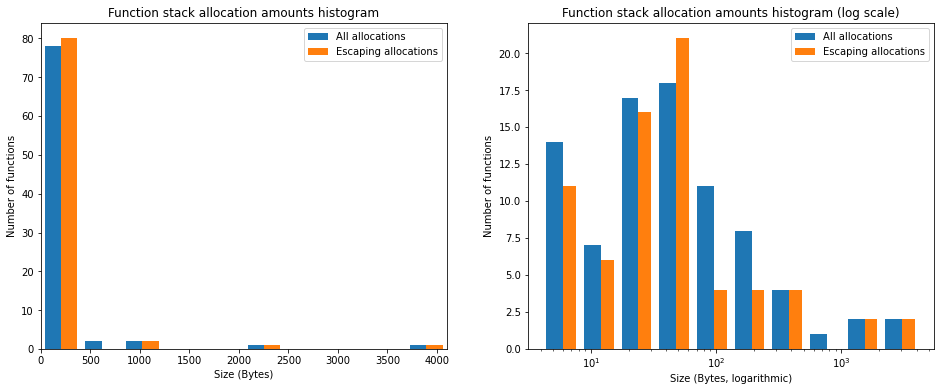

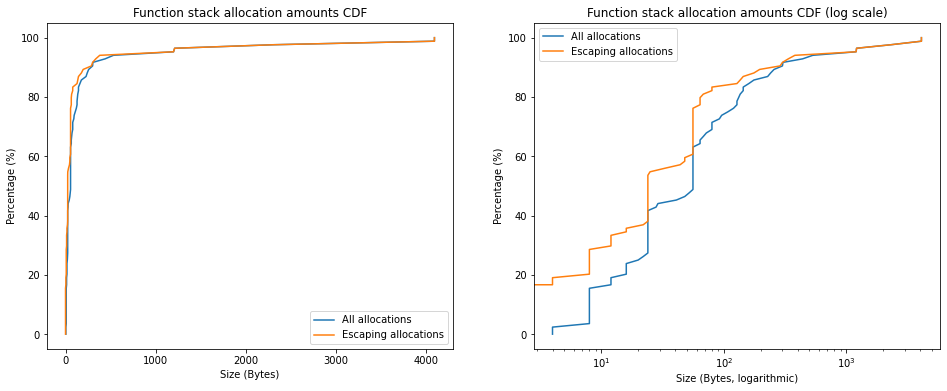

In [5]:
plot_stack_allocation_histograms(grep_dynamic_data_no_empty_frames)
plot_stack_allocation_CDFs(grep_dynamic_data_no_empty_frames)

### Main Observations

- The sizes of allocations span a large range, varying by at least three orders of magnitude.

- The majority of allocations are small, but there is a long tail. This is why there's such a huge difference between the median (58.5 bytes) and mean (257.3 bytes) stack frame sizes.

- The majority of functions make no unsafe allocations, though according to the tool, nearly 40% do (after filtering out the empty stack frames). It's worth noting that the problem of determining whether a value escapes is undecideable, so LLVM's capture tracking analysis necessarily must be an approximation with some false positives.

- Some buckets report having more unsafe allocations than total allocations. This is because the tool counts allocations at the function level, meaning that this is a histogram of functions' sizes rather than the sizes of all calls to `alloca()`. Some of these escaping calls will therefore contribute to a lower value bucket for the 'escaping allocations' histogram than the bucket they contribute to for the 'all allocations' histogram. It wouldn't make sense for a function to allocate more possibly-escaping memory than it allocates in total.

### Method 2: Compiled to LLVM bitcode with static linking

In [6]:
grep_static_data

,FileName,FunctionName,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
0,llvm-link,dfaerror,0,0,0,0,0,0
1,llvm-link,llvm.dbg.value,0,0,0,0,0,0
2,llvm-link,error,0,0,0,0,0,0
3,llvm-link,dfawarn,0,0,0,0,0,0
4,llvm-link,getenv,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
434,llvm-link,setlocale_null_r,0,0,0,0,0,0
435,llvm-link,setlocale_null,0,0,0,0,0,0
436,llvm-link,dup_safer,0,0,0,0,0,0
437,llvm-link,rpl_fcntl,1,1,0,0,24,24


Curiously this data also contains many empty stack frames. It's entirely possible that my Makefile is wrong and it's not actually producing a statically linked binary.

TODO: Figure out why this is happening!

In [7]:
grep_static_data_no_empty_frames

,FileName,FunctionName,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
0,llvm-link,GEAcompile,1,0,0,0,8,0
1,llvm-link,regex_compile,2,1,0,0,72,64
2,llvm-link,EGexecute,4,3,0,0,41,33
3,llvm-link,fgrep_to_grep_pattern,1,1,0,0,8,8
4,llvm-link,main,16,12,0,0,532,380
...,...,...,...,...,...,...,...,...
79,llvm-link,check_arrival_expand_ecl,1,0,0,0,24,0
80,llvm-link,expand_bkref_cache,3,2,0,0,52,48
81,llvm-link,open_safer,1,1,0,0,24,24
82,llvm-link,hard_locale,1,0,0,0,257,0


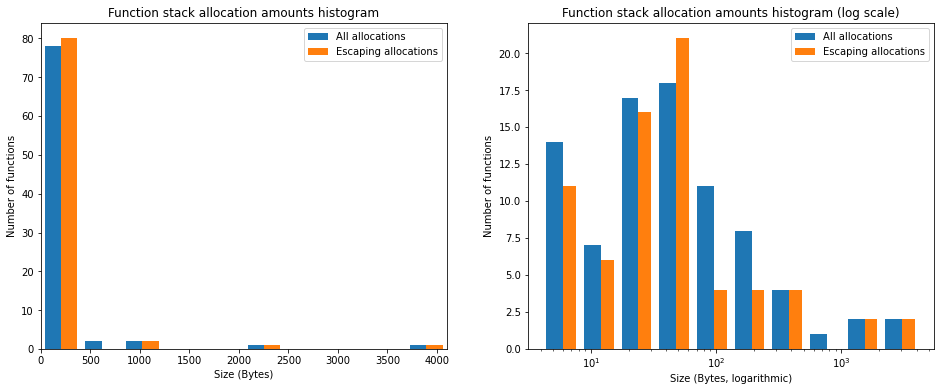

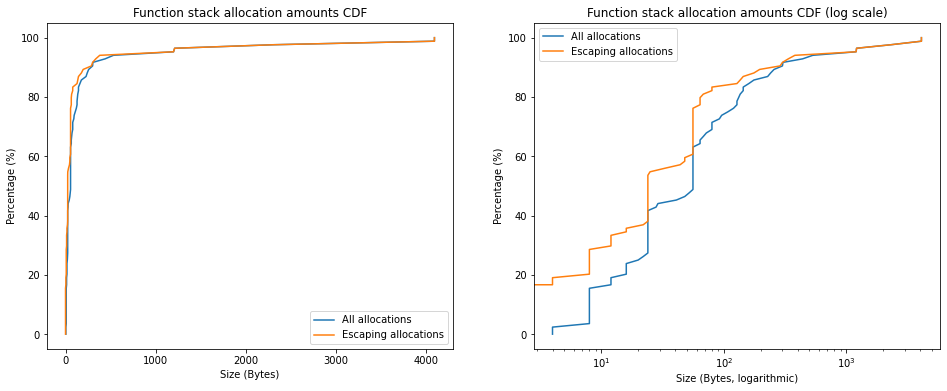

In [8]:
plot_stack_allocation_histograms(grep_static_data_no_empty_frames)
plot_stack_allocation_CDFs(grep_static_data_no_empty_frames)

## Program 2: OCaml Runtime

Next up is OCaml's runtime/interpreter, `ocamlrun`.

### The Data
Surprisingly, this data also contained a lot of empty functions.

TODO: Rerun this analysis with working static linking

In [9]:
ocamlrun_data

,FileName,FunctionName,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
0,llvm-link,caml_init_stack,0,0,0,0,0,0
1,llvm-link,llvm.dbg.value,0,0,0,0,0,0
2,llvm-link,caml_realloc_stack,0,0,0,0,0,0
3,llvm-link,llvm.memmove.p0i8.p0i8.i64,0,0,0,0,0,0
4,llvm-link,caml_ensure_stack_capacity,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1001,llvm-link,caml_debug_info_available,0,0,0,0,0,0
1002,llvm-link,caml_debug_info_status,0,0,0,0,0,0
1003,llvm-link,caml_debuginfo_location,0,0,0,0,0,0
1004,llvm-link,caml_debuginfo_extract,0,0,0,0,0,0


In [10]:
ocamlrun_data_no_empty_frames

,FileName,FunctionName,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
0,llvm-link,caml_stat_strconcat,1,1,0,0,24,24
1,llvm-link,caml_alloc_array,3,3,0,0,80,80
2,llvm-link,caml_copy_string_array,3,3,0,0,80,80
3,llvm-link,caml_alloc_some,2,2,0,0,72,72
4,llvm-link,caml_raise_with_arg,5,5,0,0,152,152
...,...,...,...,...,...,...,...,...
177,llvm-link,caml_add_debug_info,2,2,0,0,72,72
178,llvm-link,process_debug_events,6,6,0,0,160,160
179,llvm-link,caml_remove_debug_info,3,3,0,0,80,80
180,llvm-link,caml_init_debug_info,2,2,0,0,72,72


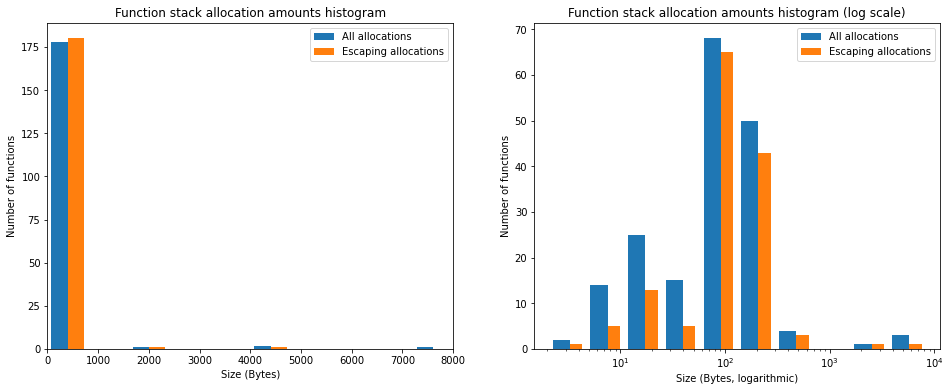

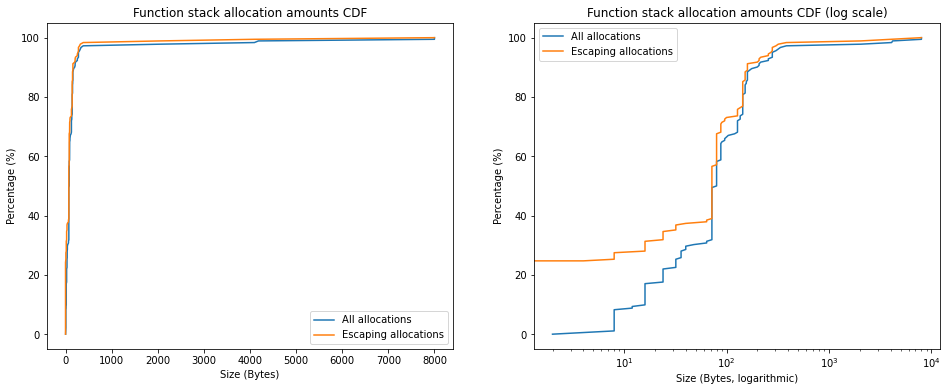

In [11]:
plot_stack_allocation_histograms(ocamlrun_data_no_empty_frames)
plot_stack_allocation_CDFs(ocamlrun_data_no_empty_frames)

### Main Observations

There are two main observations that I made here:

- The allocations on average tend to be much larger than those of Grep. Presumably this is because the runtime needs to allocate large data structures to support the program.

- This time the majority of stack-allocated memory appears to be escaping. Perhaps this is because the runtime makes use of lots of closures, which the analysis tool detects as possibly-escaping.

**TODO: I'm not sure how much to trust this analysis until I can explain why the majority of functions seemed to have empty stack frames.**

# Things left to do

- Fix statically linked builds
- Analyse Chromium source code
- Analyse LLVM source code

I also intend to do some dynamic analysis to get a feel for *stack throughput*, since right now we don't know how much each of these functions are used. The functions with the large escaping allocations don't really matter if they are only called once.